# [Going Deeper(CV)_1] ResNet Ablation Study

## * 목차

1. ResNet 기본 블록 구성하기                 
    1_1) Basic Block(기본 블록) 정의      
    1_2) Residual Block(잔여 블록) 정의            
    1_3) Resnet 모델 구조 정의<br><br>
2. ResNet-34, ResNet-50 Complete Model       
    2_1) ResNet-34          
    2_2) ResNet-50<br><br>
3. 일반 네트워크(plain network) 만들기           
    3_1) skip connection이 없는 PlainNet_34                
    3_2) skip connection이 없는 PlainNet-50<br><br>
4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34          
    4_1) cats_vs_dogs 데이터셋 준비           
    4_2) Input Normalization         
    4_3) 모델 학습        
      4_3_1) resnet_34 학습       
      4_3_2) plain_34 학습     
      4_3_3) resnet_50 학습       
      4_3_4) plain_50 학습<br><br>  
5. 시각화     
    5_1) ResNet-34 vs Plain-34      
    5_2) ResNet-50 vs Plain-50<br><br>
6. Ablation Study 결과표        

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. ResNet 기본 블록 구성하기

### 1_1) Basic Block(기본 블록) 정의

In [3]:
def basic_block(input_layer, num_cnn, is_50, is_skip, channel, stage):
    
    bn_axis = 3 # 채널 값
    x = input_layer
    
    # layers name format
    for i, cnn_num in enumerate(range(num_cnn)):
        name_format = 'stage' + str(stage + 2) + '_' + str(i+2) + '_'
  
        if is_50 is False: # resnet34
            input_layer = x

            # convolution layer x 2 
            x = keras.layers.Conv2D(channel, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv1')(x) # 3x3 필터를 사용
            x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn1')(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(channel, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv2')(x)  # 3x3 필터를 사용
            x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn2')(x)
            x = keras.layers.Activation('relu')(x)
        

        elif is_50 is True: # resnet50
            input_layer = x 

            # convolution layer x 3
            x = keras.layers.Conv2D(channel, kernel_size = (1,1), kernel_initializer = 'he_normal', name = name_format + 'conv1')(input_layer) # 1x1 필터를 사용
            x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn1')(x)
            x = keras.layers.Activation('relu')(x)
    
            x = keras.layers.Conv2D(channel, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv2')(x) # 3x3 필터를 사용
            x = keras.layers.BatchNormalization(axis = bn_axis, name=name_format + 'bn2')(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(channel*4, kernel_size = (1,1), kernel_initializer = 'he_normal', name = name_format + 'conv3')(x) # 1x1 필터를 사용
            x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn3')(x)
            x = keras.layers.Activation('relu')(x)
            
        # skip connection        
        if is_skip is True:
            x = keras.layers.add([x, input_layer], name = name_format + 'add') # convolution layer 마다 add
        x = keras.layers.Activation('relu')(x) # add 의 결과에 relu

    return x

### 1_2) Residual Block(잔여 블록) 정의

In [4]:
def residual_block(input_layer, is_50, is_skip, channel, stage):
      
    bn_axis = 3 # 채널 값
    name_format = 'stage' + str(stage + 2) + '_1_' # layers name format
  
    # 너비와 높이를 줄이기 위해 straide 값 설정
    if stage is 0:
        strides = 1 # 첫번째 stage, 입력값과 출력값의 차원이 같은 경우
    else:           
        strides = 2 # 그 외 stage, 입력값과 출력값의 차원이 다를 경우
        
    if is_50 is False: # resnet34

        # Dimension(차원)을 맞춰주기 위해, 같은 stride 값을 사용
        x = keras.layers.Conv2D(channel, kernel_size = (3,3), strides = strides, padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv1')(input_layer)
        x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn1')(x)
        x = keras.layers.Activation('relu')(x)
        
        x = keras.layers.Conv2D(channel, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv2')(x)
        x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn2')(x)
        x = keras.layers.Activation('relu')(x)
         
        shortcut = keras.layers.Conv2D(channel, kernel_size = (1,1), strides = strides, padding='same', kernel_initializer = 'he_normal', name = name_format + 'short')(input_layer)
        shortcut = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn3')(shortcut)


    elif is_50 is True: # resnet50

        # Dimension(차원)을 맞춰주기 위해, 같은 stride 값을 사용
        x = keras.layers.Conv2D(channel, kernel_size = (1,1), strides = strides, kernel_initializer = 'he_normal', name = name_format + 'conv1')(input_layer)
        x = keras.layers.BatchNormalization(axis=bn_axis, name = name_format + 'bn1')(x)
        x = keras.layers.Activation('relu')(x)

        x = keras.layers.Conv2D(channel, kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal', name = name_format + 'conv2')(x)
        x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn2')(x)
        x = keras.layers.Activation('relu')(x)

        x = keras.layers.Conv2D(channel*4, kernel_size = (1,1), kernel_initializer = 'he_normal', name = name_format + 'conv3')(x)
        x = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn3')(x)
        x = keras.layers.Activation('relu')(x)

        # Dimension(차원)을 맞춰주기 위해, 같은 stride 값을 사용    
        shortcut = keras.layers.Conv2D(channel*4, kernel_size = (1,1), strides = strides, kernel_initializer = 'he_normal', name = name_format + 'short')(input_layer)
        shortcut = keras.layers.BatchNormalization(axis = bn_axis, name = name_format + 'bn4')(shortcut)
  
    # skip connection   
    if is_skip is True: # convolution layer 마다 add, relu
        x = keras.layers.add([x, shortcut], name = name_format + 'add')
        x = keras.layers.Activation('relu')(x)

    return x

### 1_3) Resnet 모델 구조 정의

In [5]:
def build_resnet(input_shape = (32,32,3), num_cnn_list = [2,3,5,2], channel_list = [64,128,256,512], is_50 = False, is_skip = True, num_classes = 10):

    # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    assert len(num_cnn_list) is len(channel_list)

    # input layer를 만들어둡니다.    
    input_layer = keras.layers.Input(shape = input_shape, name='input_layer')
  
    # 입력 레이어
    output = input_layer

    # CNN 레이어  
    output = keras.layers.Conv2D(64, kernel_size = (7,7), strides = 2, padding='same', name='stage1_1_conv1')(output)
    output = keras.layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = keras.layers.Activation('relu')(output)
  
    # Max Pooling 레이어
    output = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.  
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = residual_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
            )

    output = basic_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
            )
           
    output = keras.layers.AveragePooling2D(pool_size = (1,1), name = 'avg_pool')(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

## 2. ResNet-34, ResNet-50 Complete Model

### 2_1) ResNet-34

In [6]:
resnet_34 = build_resnet(input_shape = (32,32,3), is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
______________________________________________________________________________________________

### 2_2) ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape = (32,32,3), is_50 = True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## 3. 일반 네트워크(plain network) 만들기

### 3_1) skip connection이 없는 PlainNet_34

In [8]:
# build_resnet() -> is_skip 사용
PlainNet_34 = build_resnet(input_shape = (224,224,3), is_50 = False, is_skip = False)
PlainNet_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_44 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

### 3_2) skip connection이 없는 PlainNet-50

In [9]:
PlainNet_50 = build_resnet(input_shape = (224,224,3), is_50 = True, is_skip = False)
PlainNet_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_59 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

## 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### 4_1) cats_vs_dogs 데이터셋 준비

In [10]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [11]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [12]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


### 4_2) Input Normalization

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [16]:
ds_info.features["label"].num_classes

2

In [17]:
ds_info.features["label"].names

['cat', 'dog']

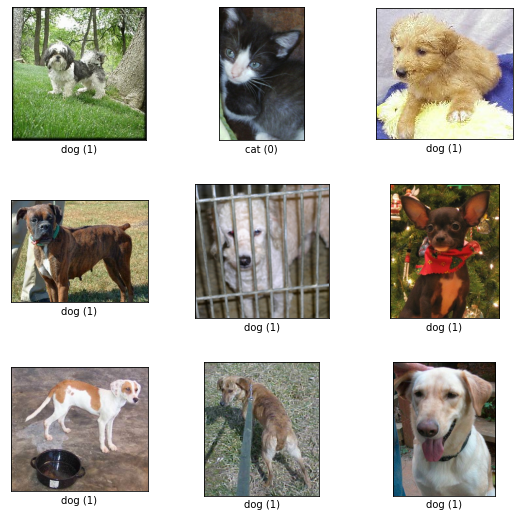

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

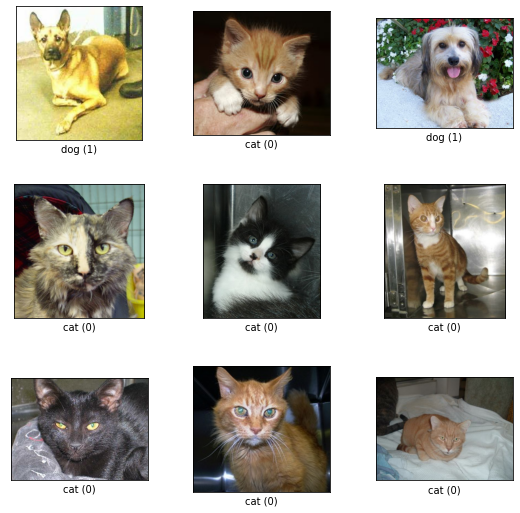

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

### 4_3) 모델 학습

In [20]:
BATCH_SIZE = 32
EPOCH = 30

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### 4_3_1) resnet_34 학습

In [22]:
resnet_34 = build_resnet(input_shape = (224,224,3), is_50 = False)

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr = 0.01, clipnorm = 1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 181s 260ms/step - loss: 1.2685 - accuracy: 0.5534 - val_loss: 1.1863 - val_accuracy: 0.5638
Epoch 2/30
581/581 [==============================] - 138s 238ms/step - loss: 0.8767 - accuracy: 0.6496 - val_loss: 1.2319 - val_accuracy: 0.6052
Epoch 3/30
581/581 [==============================] - 132s 227ms/step - loss: 0.7272 - accuracy: 0.7003 - val_loss: 1.3156 - val_accuracy: 0.5907
Epoch 4/30
581/581 [==============================] - 132s 227ms/step - loss: 0.5901 - accuracy: 0.7470 - val_loss: 1.0721 - val_accuracy: 0.6425
Epoch 5/30
581/581 [==============================] - 132s 227ms/step - loss: 0.4350 - accuracy: 0.8144 - val_loss: 1.0082 - val_accuracy: 0.6572
Epoch 6/30
581/581 [==============================] - 132s 227ms/step - loss: 0.3277 - accuracy: 0.8597 - val_loss: 0.8385 - val_accuracy: 0.7034
Epoch 7/30
581/581 [==============================] - 132s 227ms/step - loss: 0.2367 - accuracy: 0.8982 - val_loss: 1.0716 -

#### 4_3_2) plain_34 학습

In [23]:
PlainNet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = PlainNet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 128s 205ms/step - loss: 0.8511 - accuracy: 0.5411 - val_loss: 0.8129 - val_accuracy: 0.5682
Epoch 2/30
581/581 [==============================] - 119s 204ms/step - loss: 0.6879 - accuracy: 0.6331 - val_loss: 1.2686 - val_accuracy: 0.5355
Epoch 3/30
581/581 [==============================] - 119s 204ms/step - loss: 0.6310 - accuracy: 0.6676 - val_loss: 0.7064 - val_accuracy: 0.6374
Epoch 4/30
581/581 [==============================] - 119s 204ms/step - loss: 0.5743 - accuracy: 0.7082 - val_loss: 0.7170 - val_accuracy: 0.6534
Epoch 5/30
581/581 [==============================] - 119s 204ms/step - loss: 0.5113 - accuracy: 0.7479 - val_loss: 0.6419 - val_accuracy: 0.6823
Epoch 6/30
581/581 [==============================] - 119s 204ms/step - loss: 0.4249 - accuracy: 0.8037 - val_loss: 0.7065 - val_accuracy: 0.6911
Epoch 7/30
581/581 [==============================] - 119s 205ms/step - loss: 0.3114 - accuracy: 0.8631 - val_loss: 0.7375 -

#### 4_3_3) resnet_50 학습

In [24]:
resnet_50 = build_resnet(input_shape = (224,224,3), is_50 = True)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 242s 371ms/step - loss: 1.7656 - accuracy: 0.5145 - val_loss: 1.1945 - val_accuracy: 0.5815
Epoch 2/30
581/581 [==============================] - 237s 408ms/step - loss: 1.3780 - accuracy: 0.5914 - val_loss: 1.2807 - val_accuracy: 0.5866
Epoch 3/30
581/581 [==============================] - 215s 370ms/step - loss: 1.2669 - accuracy: 0.6200 - val_loss: 3.2600 - val_accuracy: 0.5316
Epoch 4/30
581/581 [==============================] - 215s 371ms/step - loss: 1.2205 - accuracy: 0.6270 - val_loss: 2.8075 - val_accuracy: 0.5364
Epoch 5/30
581/581 [==============================] - 215s 370ms/step - loss: 1.1067 - accuracy: 0.6491 - val_loss: 3.8866 - val_accuracy: 0.5284
Epoch 6/30
581/581 [==============================] - 215s 370ms/step - loss: 0.9444 - accuracy: 0.6766 - val_loss: 1.2413 - val_accuracy: 0.6297
Epoch 7/30
581/581 [==============================] - 215s 370ms/step - loss: 0.8436 - accuracy: 0.6984 - val_loss: 2.1761 -

#### 4_3_4) plain_50 학습

In [25]:
PlainNet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = PlainNet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 166s 269ms/step - loss: 0.8822 - accuracy: 0.5293 - val_loss: 0.9257 - val_accuracy: 0.5207
Epoch 2/30
581/581 [==============================] - 156s 269ms/step - loss: 0.8074 - accuracy: 0.5659 - val_loss: 0.8527 - val_accuracy: 0.5707
Epoch 3/30
581/581 [==============================] - 156s 269ms/step - loss: 0.7876 - accuracy: 0.5831 - val_loss: 1.5483 - val_accuracy: 0.5323
Epoch 4/30
581/581 [==============================] - 156s 269ms/step - loss: 0.7743 - accuracy: 0.5927 - val_loss: 0.8522 - val_accuracy: 0.5660
Epoch 5/30
581/581 [==============================] - 156s 269ms/step - loss: 0.7393 - accuracy: 0.6114 - val_loss: 0.8097 - val_accuracy: 0.5803
Epoch 6/30
581/581 [==============================] - 156s 269ms/step - loss: 0.7102 - accuracy: 0.6289 - val_loss: 1.9358 - val_accuracy: 0.5276
Epoch 7/30
581/581 [==============================] - 156s 269ms/step - loss: 0.7053 - accuracy: 0.6448 - val_loss: 0.7477 -

## 5. 시각화

### 5_1) ResNet-34 vs Plain-34

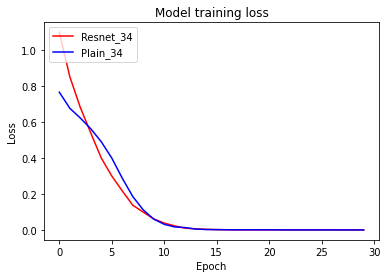

In [26]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'Plain_34'], loc='upper left')
plt.show()

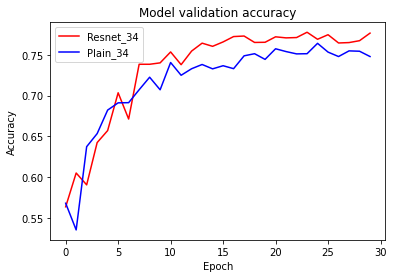

In [27]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'Plain_34'], loc='upper left')
plt.show()

### 5_2) ResNet-50 vs Plain-50

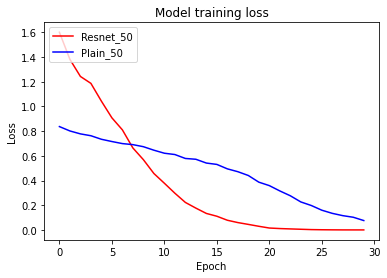

In [28]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_50', 'Plain_50'], loc='upper left')
plt.show()

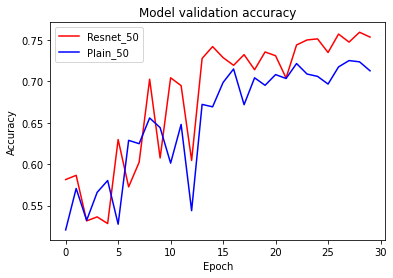

In [29]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Resnet_50', 'Plain_50'], loc='upper left')
plt.show()

## 6. Ablation Study 결과표

| Model | Loss | Accuracy |
|---|:---:|:---:|
|ResNet-34|1.0205|0.7765|
|Plain-34|1.1855|0.7478|
|ResNet-50|1.2572|0.7535|
|Plain-50|1.1508|0.7128|

#### ResNet-34 vs Plain-34 결과
* skip connection 이 없는 Plain-34, Plain-50 모델보다, ResNet-34, ResNet-50 모델의 Accuracy 높음. loss 값 또한 작음. 

#### ResNet-50 vs Plain-50 결과
* Plain-34, Plain-50 모델 중, 레이어가 더 깊은 모델(Plain-50)이 오히려 더 낮은 Accuracy 를 가짐
* ResNet 논문 내용과 같이, ResNet 모델은 이러한 degradation problem 을 해결하기 위해, shortcut connetcions(=skip connetcions) 을 사용
* 실제로 Plain-50 과 반대로 ResNet-50 모델은 더 깊은 레이어를 쌓을 수록 더욱 높은 Accuracy를 가짐을 알 수 있음